<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "5J"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/5J/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


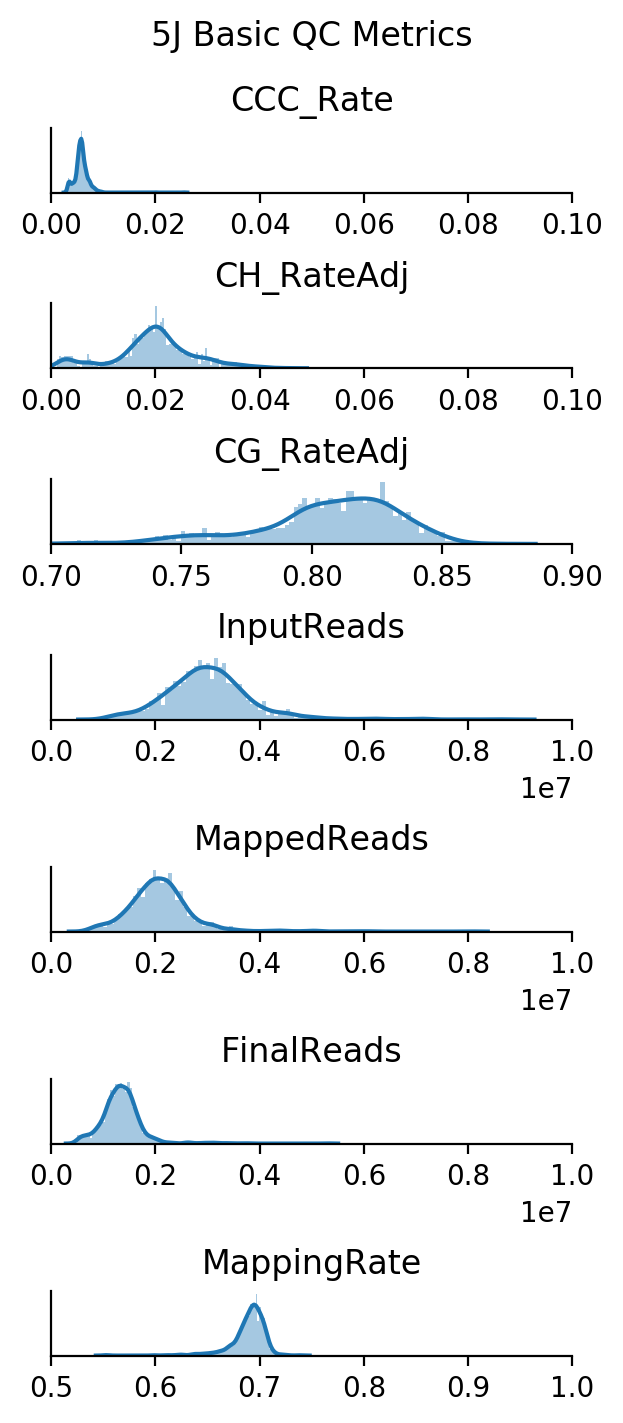

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

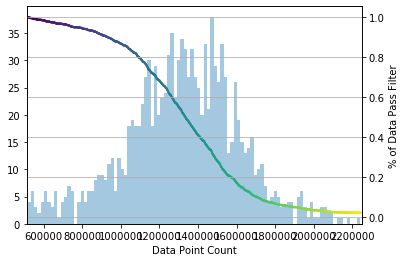

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 1234/1234 (100.0%)
CG_RateAdj passed 1234/1234 (100.0%)
CH_RateAdj passed 1234/1234 (100.0%)
FinalReads passed 1234/1234 (100.0%)
MappingRate passed 1234/1234 (100.0%)
Overall passed 1234/1234 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
190207 1234


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 148 38.5%
ad002 153 39.8%
ad004 157 40.9%
ad006 166 43.2%
ad007 156 40.6%
ad008 154 40.1%
ad010 153 39.8%
ad012 147 38.3%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
5J-2_M_0,/gale/raidix/rdx-4/mapping/5J-2/CEMBA190207-5J...,0.004962,0.818489,0.817584,0.018729,0.013836,996722.0,2053678,1417138.0,5J,...,-7.171939,3.000701,-5.089694,2.717228,LSX-Inh Dock10,12.676929,9.262974,-12.401520,-9.771739,True
5J-2_M_10,/gale/raidix/rdx-4/mapping/5J-2/CEMBA190207-5J...,0.008651,0.848647,0.847326,0.043568,0.035221,1669504.0,3822494,2649327.0,5J,...,-5.305594,2.132645,-24.058328,9.396962,LSX-Inh Cacna1i,9.555845,5.987939,-10.425874,-21.654035,True
5J-2_M_1000,/gale/raidix/rdx-4/mapping/5J-2/CEMBA190207-5J...,0.006085,0.842000,0.841033,0.029230,0.023287,1185708.0,2768252,1913645.0,5J,...,-6.717631,1.539936,-5.102325,6.822253,PAL-Inh Meis2,6.547615,7.410450,-15.069504,-2.286062,True
5J-2_M_1001,/gale/raidix/rdx-4/mapping/5J-2/CEMBA190207-5J...,0.007095,0.842160,0.841032,0.035586,0.028694,1648538.0,3940968,2741873.0,5J,...,-7.831577,0.805616,-5.793240,12.315005,PAL-Inh Onecut2,3.359077,6.694691,-36.372055,0.537560,True
5J-2_M_1002,/gale/raidix/rdx-4/mapping/5J-2/CEMBA190207-5J...,0.005303,0.822578,0.821633,0.022492,0.017280,1708992.0,4050526,2802621.0,5J,...,-7.287903,3.332164,-4.090306,1.666879,LSX-Inh Dock10,11.628711,8.209785,-12.650771,-6.726053,True
5J-2_M_1003,/gale/raidix/rdx-4/mapping/5J-2/CEMBA190207-5J...,0.005546,0.790662,0.789495,0.024503,0.019063,1544850.0,3684120,2513563.0,5J,...,-7.782535,6.272786,-5.512035,-9.193621,LSX-Inh Zeb2,15.368848,11.870277,-22.455931,16.003545,True
5J-2_M_1005,/gale/raidix/rdx-4/mapping/5J-2/CEMBA190207-5J...,0.005598,0.828542,0.827577,0.025040,0.019552,1377237.0,3278646,2244229.0,5J,...,-4.625202,3.900218,-17.118116,0.999292,LSX-Inh Nxph1,3.433492,13.350258,21.568776,-8.660020,True
5J-2_M_1007,/gale/raidix/rdx-4/mapping/5J-2/CEMBA190207-5J...,0.005325,0.829311,0.828397,0.021229,0.015989,1499436.0,3518462,2477632.0,5J,...,-6.976755,1.414812,-3.239340,6.226184,PAL-Inh Meis2,5.843123,6.601269,-20.045609,3.184753,True
5J-2_M_1008,/gale/raidix/rdx-4/mapping/5J-2/CEMBA190207-5J...,0.006046,0.821871,0.820787,0.029535,0.023631,1303829.0,2924770,2026884.0,5J,...,-8.078898,0.662676,-7.459132,13.298865,PAL-Inh Onecut2,1.564737,6.779574,-41.568801,-1.471318,True
5J-2_M_1009,/gale/raidix/rdx-4/mapping/5J-2/CEMBA190207-5J...,0.005514,0.804952,0.803871,0.021874,0.016451,1516472.0,3456028,2409066.0,5J,...,-7.186097,4.425176,-6.450079,-1.410766,LSX-Inh Zeb2,12.395905,11.523013,-11.478160,12.815412,True
